# NLP Albumentation with YELP Reviews

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.cluster import KMeansClusterer

c:\Users\echemochek\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Load Data

In [14]:
data = pd.read_csv("data/yelp.csv")
dataAug = pd.read_csv("data/yelp_augmented.csv")
dataSentiment = pd.read_csv("data/yelpSentiment.csv")
data.head(2)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0


In [15]:
dataSentiment = dataSentiment[["text", "polarity"]]
dataAug = dataAug[["augmented"]]

In [16]:
data["text"] = data["text"].str.lower()

In [17]:
data.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,my wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,i have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. rice is so good and i als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"rosie, dakota, and i love chaparral dog park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,general manager scott petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


## Exploration

<AxesSubplot:>

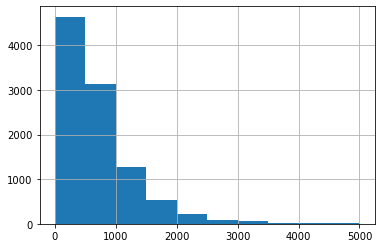

In [18]:
# length of each review
data['text'].str.len().hist()

<AxesSubplot:>

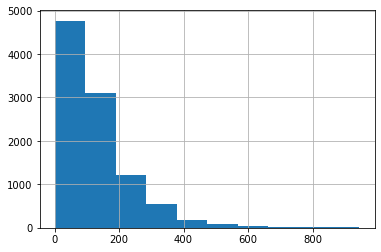

In [19]:
# number of words in each review
data['text'].str.split().map(lambda x: len(x)).hist()

<AxesSubplot:>

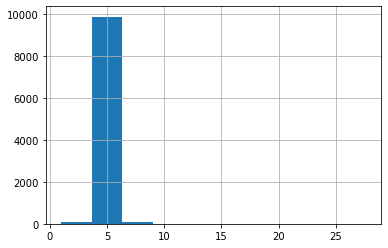

In [20]:
# average word length in each review
data['text'].str.split().apply(lambda x : [len(i) for i in x]). map(lambda x: np.mean(x)).hist()

In [21]:
# distribution of stopwords
stop = set(stopwords.words('english'))

corpus=[]
txt = data['text'].str.split()
txt = txt.values.tolist()
corpus=[word for i in txt for word in i]

from collections import defaultdict
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

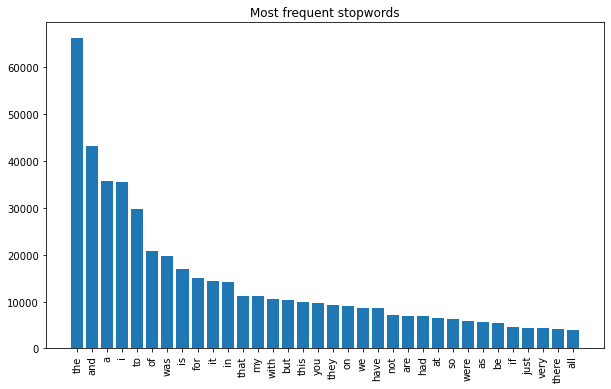

In [22]:
dic = dict(sorted(dic.items(), key=lambda item: item[1], reverse = True))
dic_subset = {key:value for key, value in dic.items() if value > 4000}

names = list(dic_subset.keys())
values = list(dic_subset.values())

plt.figure(figsize=(10,6)) 
plt.bar(range(len(dic_subset)), values, tick_label = names)
plt.title("Most frequent stopwords")
plt.xticks(rotation = 90)
plt.show()

<AxesSubplot:>

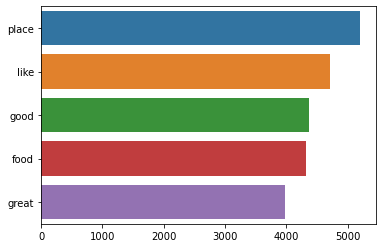

In [23]:
# most frequent non-stopwords

import collections
from collections import Counter

counter = Counter(corpus)
most = counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

In [24]:
# most frequent n-grams

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

<AxesSubplot:>

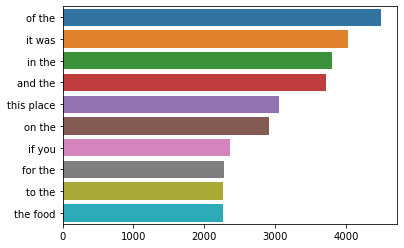

In [25]:
# bigrams
top_tri_grams = get_top_ngram(data['text'], n=2)
x,y = map(list,zip(*top_tri_grams))
sns.barplot(x=y, y=x)

<AxesSubplot:>

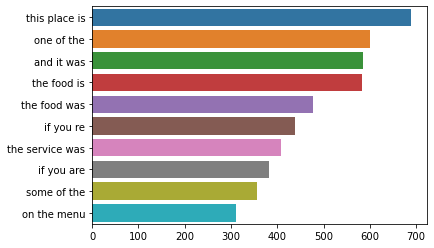

In [26]:
# trigrams
top_tri_grams = get_top_ngram(data['text'], n=3)
x,y = map(list,zip(*top_tri_grams))
sns.barplot(x=y, y=x)

## Topic Modelling with pyLDAvis

In [27]:
def preprocess_text(df):
    corpus=[]
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    for txt in data['text']:
        words=[w for w in word_tokenize(txt) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus = preprocess_text(txt)

In [28]:
# BOW model
dic_bow = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic_bow.doc2bow(doc) for doc in corpus]

In [29]:
# LDA model
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic_bow,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()


[(0,
  '0.016*"food" + 0.015*"good" + 0.014*"n\'t" + 0.014*"place" + 0.010*"great" + 0.008*"like" + 0.007*"..." + 0.007*"time" + 0.006*"service" + 0.006*"get"'),
 (1,
  '0.006*"one" + 0.006*"room" + 0.005*"well" + 0.005*"restaurant" + 0.004*"hotel" + 0.004*"great" + 0.004*"n\'t" + 0.004*"would" + 0.004*"good" + 0.004*"..."'),
 (2,
  '0.011*"n\'t" + 0.007*"store" + 0.005*"like" + 0.005*"dog" + 0.005*"place" + 0.005*"get" + 0.005*"one" + 0.004*"would" + 0.004*"time" + 0.004*"staff"'),
 (3,
  '0.014*"n\'t" + 0.011*"place" + 0.009*"time" + 0.009*"like" + 0.008*"one" + 0.008*"..." + 0.008*"get" + 0.006*"good" + 0.006*"would" + 0.006*"great"')]

In [31]:
# interacting with LDA output

#!pip install pyldavis

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

vis = gensimvis.prepare(lda_model, bow_corpus, dic_bow)
vis

c:\Users\echemochek\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.003508  0.0       1        1  50.285918
0     -0.003508  0.0       2        1  49.714082, topic_info=       Term         Freq        Total Category  logprob  loglift
69      ...  4241.000000  4241.000000  Default  30.0000  30.0000
136   thing  1730.000000  1730.000000  Default  29.0000  29.0000
171     lot  1302.000000  1302.000000  Default  28.0000  28.0000
147    love  2259.000000  2259.000000  Default  27.0000  27.0000
97    great  4862.000000  4862.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
6      back  1232.061612  2740.933112   Topic2  -5.5859  -0.1007
69      ...  1640.224084  4241.712253   Topic2  -5.2998  -0.2513
138     try   875.970373  1669.510544   Topic2  -5.9270   0.0539
190  always   955.125955  1926.885041   Topic2  -5.8405  -0.0029
398  little   989.382786  2117.657195   Topic2  -5.8053  -0.0621

[210 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
11202      1  0.788921  'panini
11202      2  0.262974  'panini
344        1  0.438143      're
344        2  0.561881      're
0          1  0.474878      've
...      ...       ...      ...
142        2  0.437745    would
26096      1  0.701176      xao
26096      2  0.350588      xao
13587      1  0.810519      zia
13587      2  0.243156      zia

[313 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

## Wordcloud

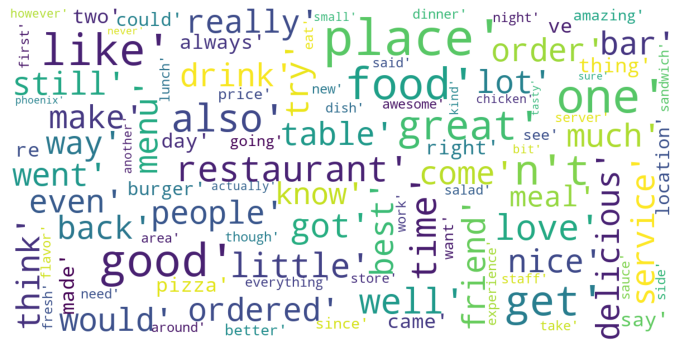

In [32]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=42)
   
    wordcloud = wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

## Sentiment

<AxesSubplot:>

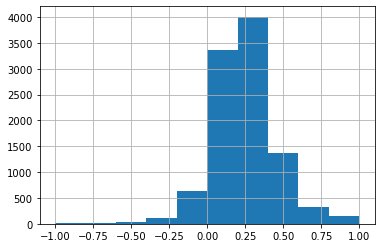

In [33]:
from textblob import TextBlob

def polarity(text):
    return TextBlob(text).sentiment.polarity

data['polarity_score']= data['text'].apply(lambda x : polarity(x))
data['polarity_score'].hist()

In [ ]:
def sentiment(x):
    if x< -0.2:
        return 'neg'
    elif x>=-0.2 and x<=0.2:
        return 'neu'
    else:
        return 'pos'
    
data['polarity'] = data['polarity_score'].map(lambda x: sentiment(x))

plt.figure(figsize=(8,6))
plt.bar(data.polarity.value_counts().index,
        data.polarity.value_counts()) 
plt.title("Polarity of Reviews")

In [ ]:
# data.to_csv("data/yelpSentiment.csv")

# NER

In [ ]:
# !python -m spacy download en_core_web_sm

In [ ]:
nlp = spacy.load("en_core_web_sm")

def ner(text):
    doc = nlp(text)
    return [X.label_ for X in doc.ents]

ent = data['text'].apply(lambda x : ner(x))
ent = [x for sub in ent for x in sub]

counter = Counter(ent)
count = counter.most_common()

In [ ]:
# entity frequencies visualization
x,y = map(list,zip(*count))
sns.barplot(x=y, y=x)

In [ ]:
# we can then visualize token per entity

def ner(text,ent="ORG"):
    doc = nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

org = data['text'].apply(lambda x: ner(x))
org = [i for x in org for i in x]
counter = Counter(org)

x,y = map(list,zip(*counter.most_common(10)))
sns.barplot(y, x)

## POS Exploration

In [ ]:
def pos(text):
    pos=nltk.pos_tag(word_tokenize(text))
    pos=list(map(list,zip(*pos)))[1]
    return pos

tags = data['text'].apply(lambda x : pos(x))
tags=[x for l in tags for x in l]
counter = Counter(tags)

x,y = list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

- Noun (NN)
- Verb (VB)
- Adjective (JJ)
- Adverb(RB)
- Preposition (IN)
- Conjunction (CC)
- Pronoun(PRP)
- Interjection (INT)

In [ ]:
# drilling down even further: looking at NN
def get_adjs(text):
    adj=[]
    pos = nltk.pos_tag(word_tokenize(text))
    for word,tag in pos:
        if tag=='NN':
            adj.append(word)
    return adj


words = data['text'].apply(lambda x : get_adjs(x))
words = [x for l in words for x in l]
counter = Counter(words)

x,y = list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y, y=x)

### Embeddings with BERT (Hugging Face's transformer architecture)

In [ ]:
# be sure to download the pretrained transformer via the spaCy pipeline
# !spacy download en_core_web_trf

In [ ]:
# !pip install spacy-transformers

In [ ]:
import en_core_web_trf

In [ ]:
txt = "The quick brown fox jumps over the lazy dog"

In [ ]:
#Load the bert model
nlp = en_core_web_trf.load()#spacy.load("en_core_web_trf", disable=["tagger", "attribute_ruler", "lemmatizer"])

# get sentence embeddings from input text
def get_embeddings(text):
    return nlp(text).vector

In [ ]:
# Generating sentence embedding from the text
# data['embeddings'] = data['text'].apply(get_embeddings)

df = get_embeddings(txt)
df

### Transformer outputs sequences longer than the maximum length for the model (537 > 512). We will truncate the output.

In [ ]:
# it takes time to run BERT so its better to save the updated data for future use
# data.to_csv("data/yelp_embeddings.csv")

In [ ]:
# df = pd.read_csv("data/yelp_embeddings.csv")

In [ ]:
dataSentiment.head(1)

In [7]:
dataAug["polarity"] = dataSentiment["polarity"]
dataAug.rename(columns={"augmented": "text"}, inplace = True)
dataAug.head(3)

,text,polarity
0,My girlfriend took me here on my anniversary f...,pos
1,I have no think why some people give bad revie...,pos
2,love the crust plate. gearloose is so good and...,pos


In [8]:
merged_df = dataSentiment.append(dataAug, ignore_index=True)
merged_df.shape

(20000, 3)

## Base Clustering Algorithm

In [ ]:
## Import libraries
def clustering_question(data, NUM_CLUSTERS = 15):

    sentences = data['text']

    X = np.array(data['emb'].tolist())

    kclusterer = KMeansClusterer(
        NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance,
        repeats=25,avoid_empty_clusters=True)

    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

    data['cluster'] = pd.Series(assigned_clusters, index=data.index)
    data['centroid'] = data['cluster'].apply(lambda x: kclusterer.means()[x])

    return data, assigned_clusters

In [ ]:
def distance_from_centroid(row):
    # type of emb and centroid is different, hence using tolist below
    return distance_matrix([row['emb']], [row['centroid'].tolist()])[0][0]

# Compute centroid distance to the data
data['distance_from_centroid'] = data.apply(distance_from_centroid, axis=1)

In [12]:
# df = dataSentiment.copy()
df = data.copy()

In [13]:
df.head()

,text
0,My wife took me here on my birthday for breakf...
1,I have no idea why some people give bad review...
2,love the gyro plate. Rice is so good and I als...
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!..."
4,General Manager Scott Petello is a good egg!!!...


## Base Classifier Algorithm

In [14]:
dataSentiment.head()

,text,polarity,category
0,My wife took me here on my birthday for breakf...,pos,2
1,I have no idea why some people give bad review...,pos,2
2,love the gyro plate. Rice is so good and I als...,pos,2
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",pos,2
4,General Manager Scott Petello is a good egg!!!...,pos,2


In [15]:
# label encoding the classes
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

encoder.fit(dataSentiment['polarity'])

dataSentiment['category'] = encoder.transform(dataSentiment['polarity'])
merged_df['category'] = encoder.transform(merged_df['polarity'])

# train-test split
def splitStep(df=dataSentiment, X="text", y="category", test_size=0.2, random_state=42):
    from sklearn.model_selection import train_test_split

    xtrain, xtest, ytrain, ytest = train_test_split(dataSentiment[X], dataSentiment[y], stratify=dataSentiment[y], test_size=test_size)

    return xtrain, xtest, ytrain, ytest


# word vectorizer
def w2v(x, num_features=100): # xtrain & xtest will be accessed from the vectorizeStep (ignore warning)
    import numpy as np
    from gensim.models import Word2Vec

    wordvec = Word2Vec(x, window=8, min_count=2, sample=1e-3, sg=1, workers=8) 
    vocab = set(wordvec.wv.index_to_key)
    num_features = num_features

    def average_word_vectors(tokens, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        ntokens = 0.
        for t in tokens:
            if t in vocabulary: 
                ntokens = ntokens + 1.
                feature_vector = np.add(feature_vector, model.wv[t])
        if ntokens:
            feature_vector = np.divide(feature_vector, ntokens)
        return feature_vector

    xTransformed = np.array([average_word_vectors(sent_tokens, wordvec, vocab, num_features) 
                    for sent_tokens in x]) 
    return xTransformed


# document vectorizer
def d2v(x):
    from gensim.models.doc2vec import Doc2Vec, TaggedDocument

    docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(x)]
    docvec = Doc2Vec(vector_size=100, window=3, min_count=4, workers=4, epochs=40)
    docvec.build_vocab(docs)
    docvec.train(docs, total_examples=docvec.corpus_count, epochs=docvec.epochs)

    from gensim.utils import simple_preprocess
    xTokenized = [simple_preprocess(h) for h in x]

    xTransformed = [docvec.infer_vector(i) for i in xTokenized]

    return xTransformed


# transform data (options: TF-IDF, TF-IDF ngrams, word2vec, doc2vec)
def vectorizeStep(inputData, fittingData=df.text, outputFormat="tfidf"):
    
    # TF-IDF input
    if outputFormat == "tfidf":
        from sklearn.feature_extraction.text import TfidfVectorizer
        vectorizer = TfidfVectorizer(
                            strip_accents="unicode", lowercase=True, analyzer='word', 
                            stop_words='english', max_df=0.95, min_df=0.05, max_features=500
                                )
        vectorizer.fit(fittingData)
        
        transformedData = vectorizer.transform(inputData)
    
    # TF-IDF ngrams input
    elif outputFormat == "ngrams":
        from sklearn.feature_extraction.text import TfidfVectorizer
        vectorizer = TfidfVectorizer(
                            strip_accents="unicode", lowercase=True, analyzer='word', ngram_range=(2,3), 
                            max_df=0.95, min_df=0.05, max_features=500
                            )
        vectorizer.fit(fittingData)
        
        transformedData = vectorizer.transform(inputData)

    # word vector input
    elif outputFormat == "word2vec":
        transformedData = w2v(inputData)

    # document vector input
    elif outputFormat == "doc2vec":
        transformedData = d2v(inputData)
        
    return transformedData


# train models
def trainStep(classifier: str, x_input, y_input):
    
    # import GridSearchCV
    from sklearn.model_selection import GridSearchCV

    # create a SVC model using GridSearchCV
    if classifier == "svc":
        
        # import SVC
        from sklearn.svm import SVC

        param_grid = {
                        'C': [0.1, 1, 10, 100, 1000],'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                        'kernel': ['linear', 'rbf', 'sigmoid']} 
        

        
        model = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

    # create an XGBoost model
    elif classifier == "xgboost":
        import xgboost
        model = xgboost.XGBClassifier()

    # create a knn model
    elif classifier == "knn":

        # import KNN
        from sklearn.neighbors import KNeighborsClassifier

        k_range = list(range(1, 31))
        param_grid = dict(n_neighbors=k_range)
        
        model = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='accuracy')
    
    m = model.fit(x_input, y_input)
    
    return m


# predict on the xtest 
def predictStep(trainedModel, x_input):
    predictions = trainedModel.predict(x_input)
    return predictions

# evaluate on ytest 
def evaluateStep(ytrue, ypred):
    from sklearn.metrics import precision_recall_fscore_support as score
    from sklearn.metrics import accuracy_score
    
    precision,recall,fscore,_=score(ytrue,ypred, average='macro')
    accuracy = accuracy_score(ytrue,ypred)

    return round(precision,4), round(recall,4), round(fscore,4), round(accuracy,4) #,roc_auc
    

In [16]:
# dictionary to store f1 scores of different models
f1ScoreMetrics = {'xgboost': [],'knn': []}

# dictionary to store accuracy scores of different models
accuracyScoreMetrics = {'xgboost': [],'knn': []}

In [17]:
# train-test split the data 
xTrn, xTst, yTrn, yTst = splitStep(df=df, X="text", y="category")

# models and inputs
modelList = ['xgboost', 'knn']
dataFormats = ['tfidf', 'ngrams']
trainedModels = [] # to store the models we train to use later

# fit model, train on training data, test on the testing set, append scores to dictionaries
for model in modelList:
    for dataFormat in dataFormats:

        # vectorize
        xtrainVectorized = vectorizeStep(xTrn, outputFormat=dataFormat)
        xtestVectorized = vectorizeStep(xTst, outputFormat=dataFormat)

        # train
        trainedModel = trainStep(model, xtrainVectorized, yTrn)

        # predict
        ypreds = predictStep(trainedModel, xtestVectorized)

        # evaluate
        metrics = evaluateStep(yTst, ypreds)

        # append trained models to a list and metrics to a dictionary
        trainedModels.append(trainedModel) 
        f1ScoreMetrics[model].append(metrics[2])
        accuracyScoreMetrics[model].append(metrics[3])

c:\Users\echemochek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:11:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\echemochek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:11:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\echemochek\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\echemochek\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
# function for highlighting best model
def highlight_cells(val):
    color = 'yellow' if val == maxVal else ''
    return 'background-color: {}'.format(color)


# display f1 scores in a formatted dataframe
f1_df = pd.DataFrame.from_dict(f1ScoreMetrics)
f1_df.set_index([pd.Index(dataFormats)], inplace=True)

maxVal = f1_df.max().max()
f1_df.style.applymap(highlight_cells)

,xgboost,knn
tfidf,0.531800,0.449000
ngrams,0.400300,0.361500


In [19]:
# display recall scores in a formatted dataframe
accuracy_df = pd.DataFrame.from_dict(accuracyScoreMetrics)
accuracy_df.set_index([pd.Index(dataFormats)], inplace=True)

maxVal = accuracy_df.max().max()
accuracy_df.style.applymap(highlight_cells)

,xgboost,knn
tfidf,0.754000,0.620000
ngrams,0.627500,0.614500


In [20]:
# the winning model is stored in the trainedModels list in index 4
winningModel = trainedModels[1]
winningModel

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Now use the model on augmented data

In [21]:
# dictionary to store f1 scores of different models
f1ScoreMetricsAug = {'xgboost': []}

# dictionary to store accuracy scores of different models
accuracyScoreMetricsAug = {'xgboost': []}

In [22]:
merged_df.dropna(inplace=True)

In [37]:
xTrnAug = merged_df["text"]
yTrnAug = merged_df["category"]


# vectorize
xtrainVectorizedAug = vectorizeStep(xTrnAug, fittingData=merged_df.text)

#xtestVectorized = vectorizeStep(xTst, outputFormat="tfidf")

import xgboost
modelAug = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
modelAug.fit(xtrainVectorizedAug, yTrnAug)



# train
trainedModelAug = modelAug

c:\Users\echemochek\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:28:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [43]:
myXtest = xTst.tolist()

'Highly recommend. This is my second time here and I see #3 on the way.\nI\'ve had the (bistec encebollado & arroz imperial with shrimp "no melted cheese") I do recommend both plates. Next time I will try (ropa vieja)\nGreat service! Ask for Kelly.'

In [46]:
xtestVectorized = vectorizeStep(inputData=myXtest, fittingData=merged_df.text, outputFormat="tfidf")

# predict
import numpy 
ypredsAug = predictStep(trainedModelAug, xtestVectorized)

# evaluate
metricsAug = evaluateStep(yTst, ypredsAug)

# append metrics to a dictionary
f1ScoreMetricsAug["xgboost"].append(metricsAug[2])
accuracyScoreMetricsAug["xgboost"].append(metricsAug[3])

In [49]:
f1ScoreMetricsAug

{'xgboost': [0.8612]}

In [50]:
accuracyScoreMetricsAug

{'xgboost': [0.9395]}

In [51]:
dataSentiment.head()

,text,polarity,category
0,My wife took me here on my birthday for breakf...,pos,2
1,I have no idea why some people give bad review...,pos,2
2,love the gyro plate. Rice is so good and I als...,pos,2
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",pos,2
4,General Manager Scott Petello is a good egg!!!...,pos,2
